In [37]:
using LinearAlgebra, CairoMakie

In [49]:
pars = (;α = 0.33, # Capital Share
        β = 0.95, # Discount Factor
        γ = 1.0, # CRRA Parameter
        δ = 0.1, # Depreciation Rate
        A = 2.0, # TFP
        grid_size = 1001, # Capital Grid Size
        grid_min = 0.75, # Minimum Capital (multiple of steady state)
        grid_max = 1.25, # Maximum Capital (multiple of steady state)
        maxiter = 10000, # Max Iterations
        toler = 1e-6, # Tolerance
        m = 100) # Howard Iterations

(α = 0.33, β = 0.95, γ = 1.0, δ = 0.1, A = 2.0, grid_size = 1001, grid_min = 0.75, grid_max = 1.25, maxiter = 10000, toler = 1.0e-6, m = 100)

In [50]:
function utility(c, pars)
    if pars.γ == 1
        return log(c)
    else
        return (c^(1-pars.γ))/(1-pars.γ)
    end
end

function utility_vec(c, pars)
    if pars.γ == 1
        return log.(c)
    else
        return (c.^(1-pars.γ))./(1-pars.γ)
    end
end

utility_vec (generic function with 1 method)

Iterating...
--------------------
iteration 0 completed with error 2.0494167652073187
--------------------
iteration 250 completed with error 3.064609753522518e-6
--------------------
converged in 273 iterations
--------------------
 13.349677 seconds (366.50 k allocations: 42.743 MiB, 0.07% gc time, 2.02% compilation time)


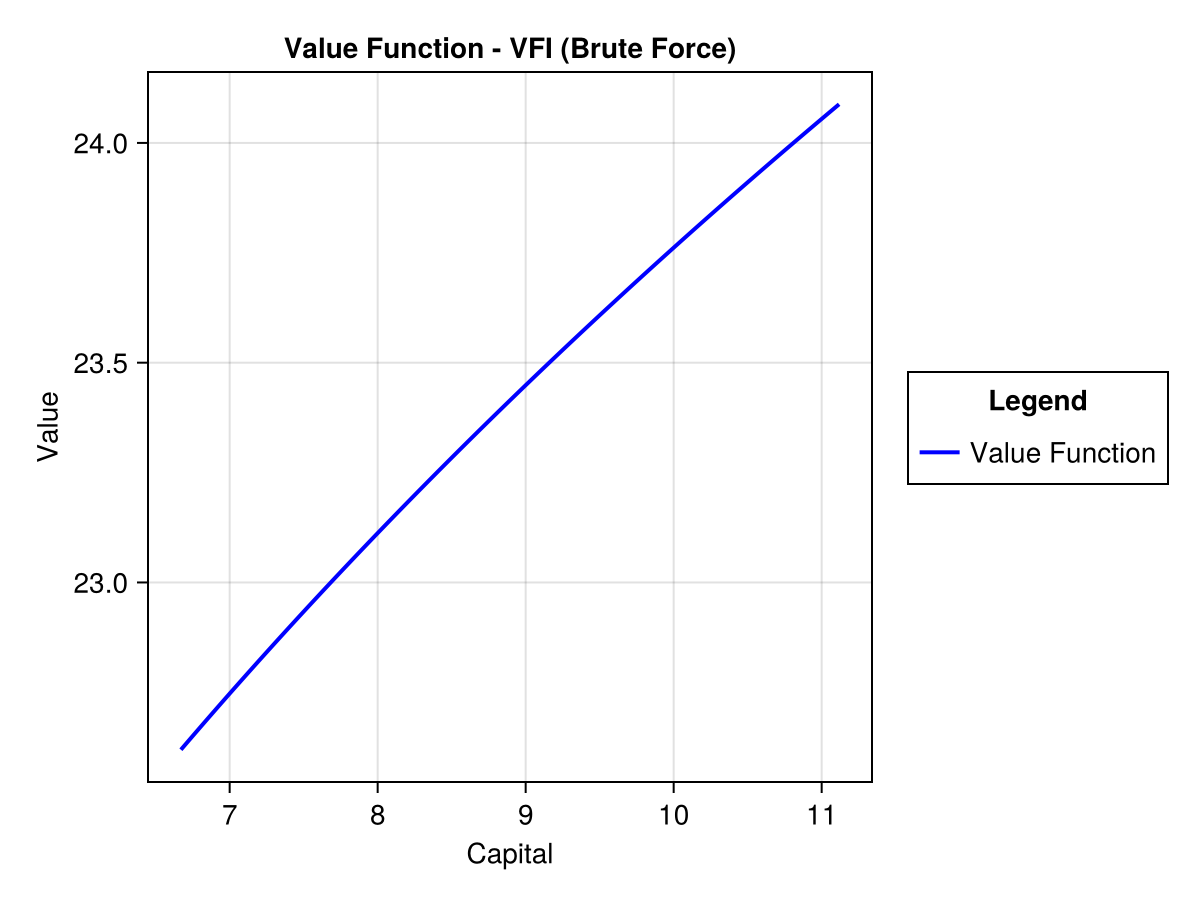

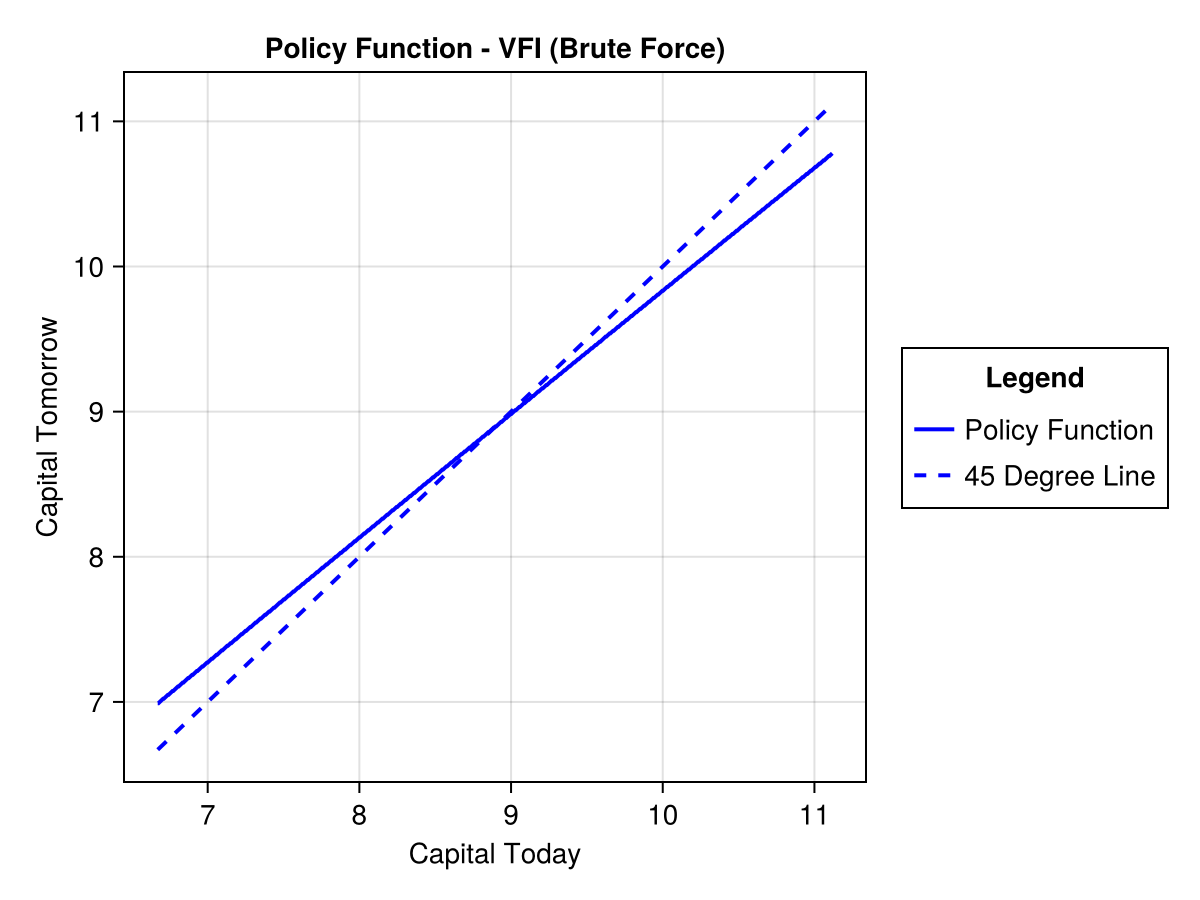

(Float32[22.619436, 22.621187, 22.622936, 22.624685, 22.626434, 22.628183, 22.62993, 22.631676, 22.63342, 22.635166  …  24.076624, 24.07788, 24.079138, 24.080395, 24.08165, 24.082907, 24.084164, 24.085419, 24.086674, 24.087929], Float32[6.9907913, 6.9907913, 6.9952383, 6.9996853, 7.0041323, 7.0085797, 7.0130267, 7.0174737, 7.0219207, 7.0219207  …  10.744117, 10.748564, 10.753011, 10.757458, 10.761905, 10.761905, 10.766353, 10.7708, 10.775247, 10.779694])

In [51]:
function vfi_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = similar(v)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                    end
                end
            end
            v_new[i] = vmax
            dist[i] = v_new[i] - v[i]
        end
        error = maximum(dist)
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new)
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Brute Force)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_out_nt, pol_out_nt = vfi_nt_brute_force(zeros(pars.grid_size,1), pars)
end

Iterating...
--------------------
iteration 0 completed with error 2.0494167652073187
--------------------
iteration 250 completed with error 3.064609753522518e-6
--------------------
converged in 273 iterations
--------------------
  4.558546 seconds (674.69 k allocations: 4.293 GiB, 5.76% gc time, 20.10% compilation time)


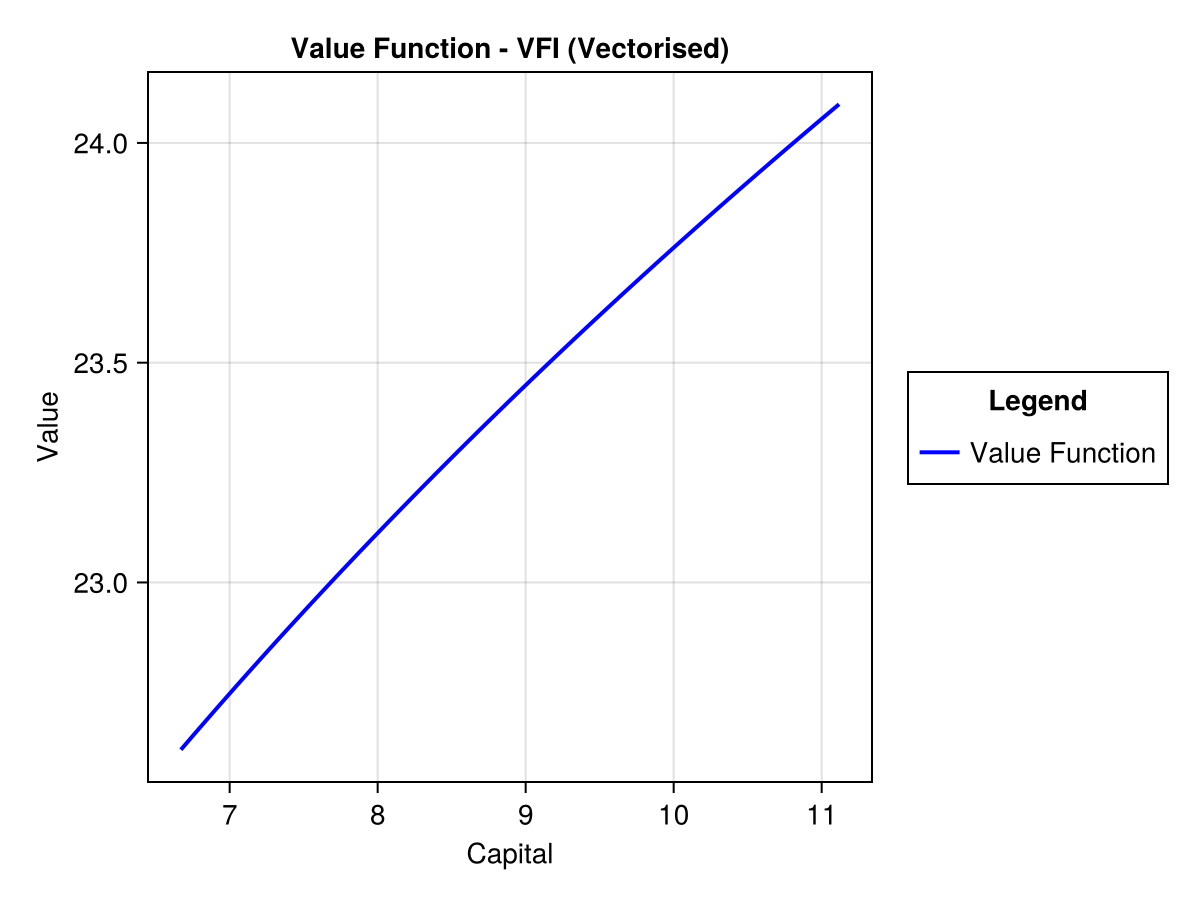

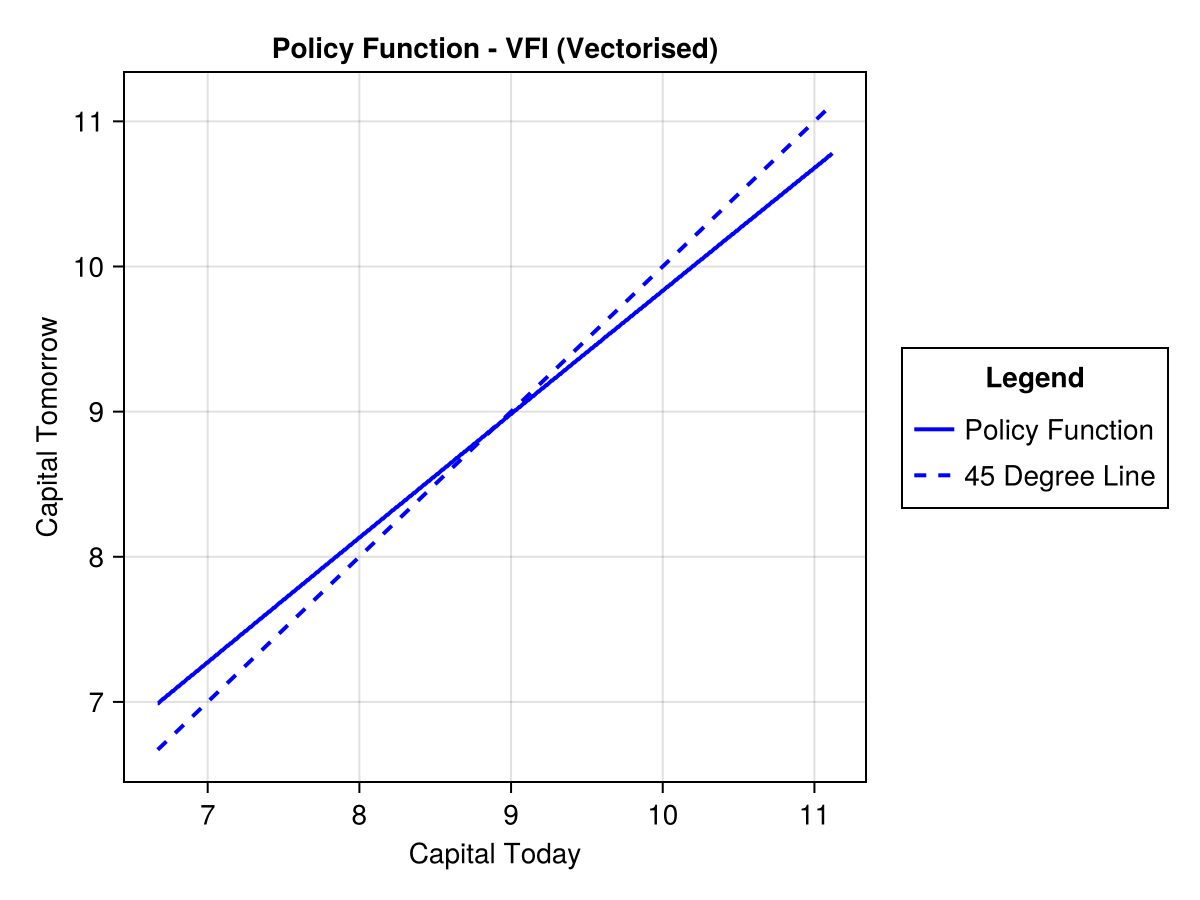

(Float32[22.619436, 22.621187, 22.622936, 22.624685, 22.626434, 22.628183, 22.62993, 22.631676, 22.63342, 22.635166  …  24.076624, 24.07788, 24.079138, 24.080395, 24.08165, 24.082907, 24.084164, 24.085419, 24.086674, 24.087929], Float32[6.9907913, 6.9907913, 6.9952383, 6.9996853, 7.0041323, 7.0085797, 7.0130267, 7.0174737, 7.0219207, 7.0219207  …  10.744117, 10.748564, 10.753011, 10.757458, 10.761905, 10.761905, 10.766353, 10.7708, 10.775247, 10.779694])

In [52]:
function vfi_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    pos_c = cons .* c_pos
    while ((error > toler) && (iter < maxiter))
        v_new = utility_vec(pos_c, pars) .+ β.*transpose(v)
        v_new[.!c_pos] .= -Inf
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]] 
        error = maximum(vmax .- v)
        v .= vmax
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Vectorised)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_out_nt_vec, pol_out_nt_vec = vfi_nt_vectorised(zeros(pars.grid_size,1), pars)
end 

Iterating...
--------------------
iteration 0 completed with error 17.601785525212154
--------------------
converged in 69 iterations
--------------------
  4.001632 seconds (397.62 k allocations: 44.279 MiB, 11.59% compilation time)


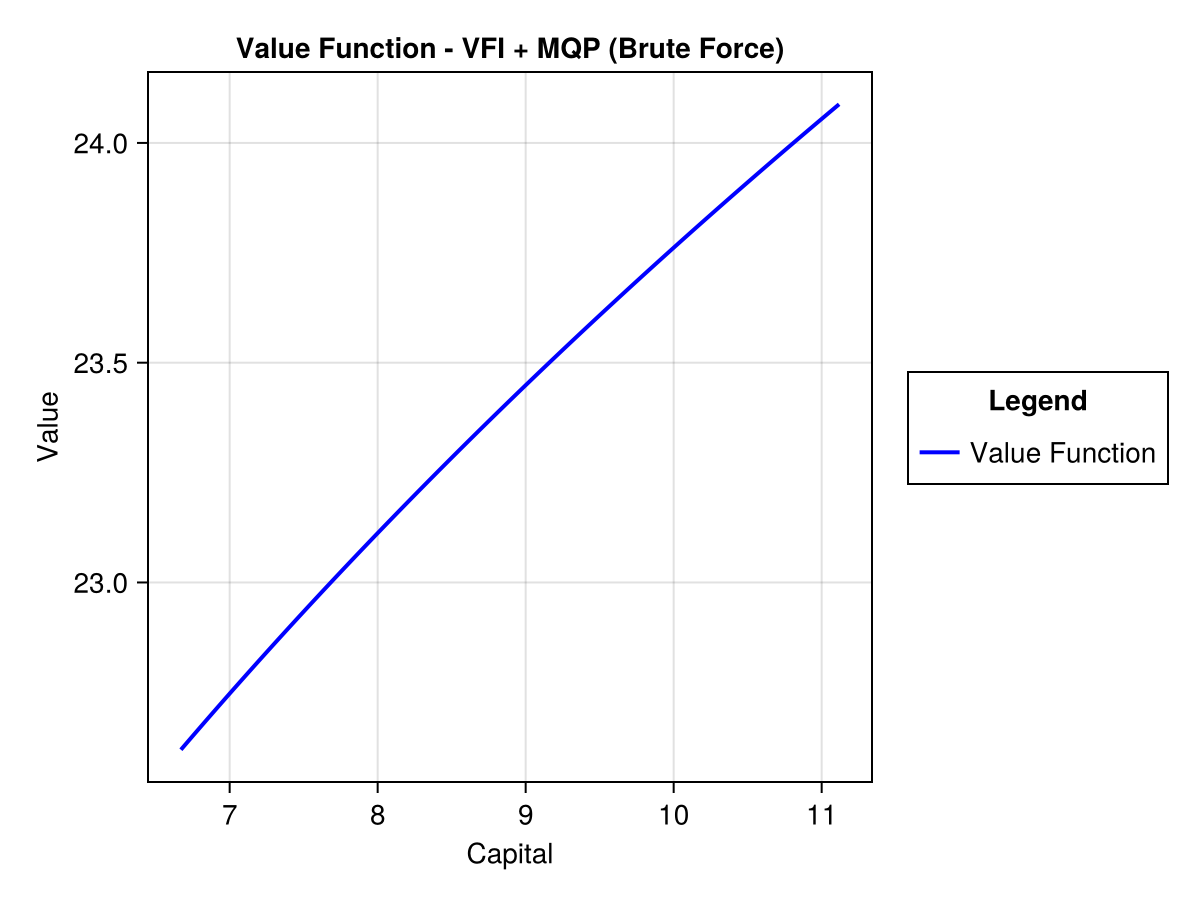

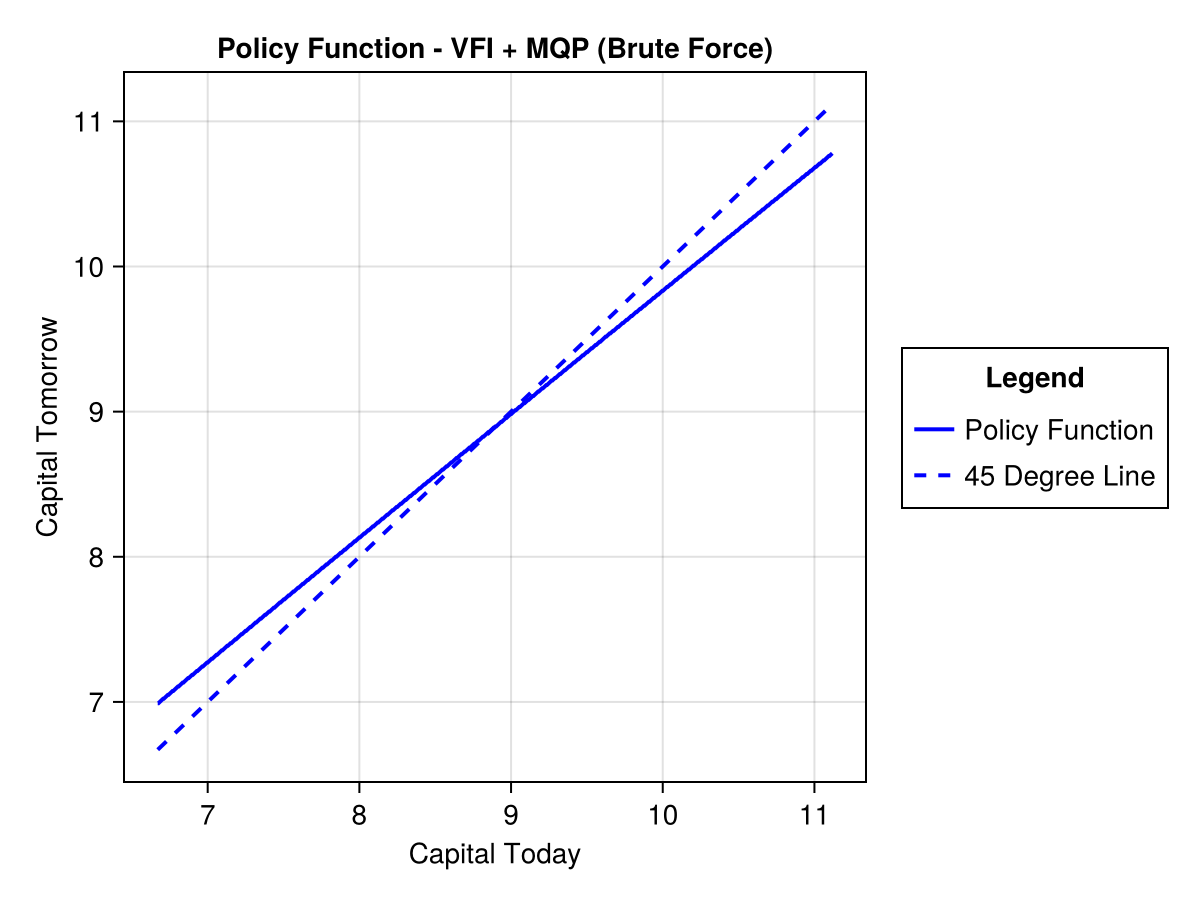

(Float32[22.619455, 22.621206, 22.622955, 22.624704, 22.626453, 22.628202, 22.629948, 22.631695, 22.63344, 22.635185  …  24.076641, 24.077898, 24.079155, 24.080412, 24.081669, 24.082926, 24.08418, 24.085438, 24.086693, 24.087946], Float32[6.9907913, 6.9907913, 6.9952383, 6.9996853, 7.0041323, 7.0085797, 7.0130267, 7.0174737, 7.0219207, 7.0219207  …  10.744117, 10.748564, 10.753011, 10.757458, 10.761905, 10.761905, 10.766353, 10.7708, 10.775247, 10.779694])

In [53]:
function mqp_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = similar(v)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                    end
                end
            end
            v_new[i] = vmax
            dist[i] = v_new[i] - v[i]
        end
        low_bound = minimum(v_new .- v) .* (β / (1 - β))
        high_bound = maximum(v_new .- v) .* (β / (1 - β))
        error = high_bound - low_bound
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new) .+ (low_bound + high_bound)/2
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI + MQP (Brute Force)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI + MQP (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_mqp_nt, pol_mqp_nt = mqp_nt_brute_force(zeros(pars.grid_size,1), pars)
end 

Iterating...
--------------------
iteration 0 completed with error 17.601785525212154
--------------------
converged in 69 iterations
--------------------
  2.086485 seconds (667.94 k allocations: 1.144 GiB, 3.54% gc time, 47.88% compilation time)


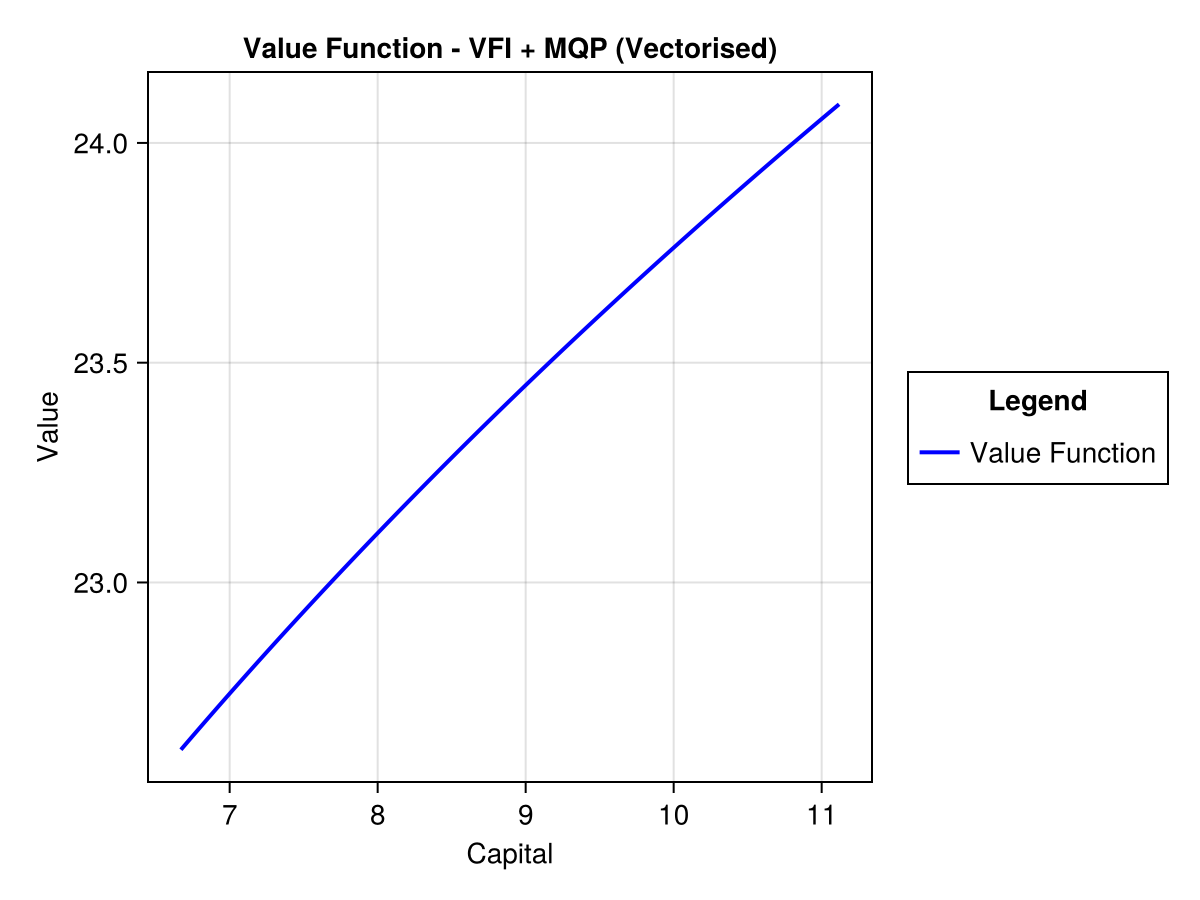

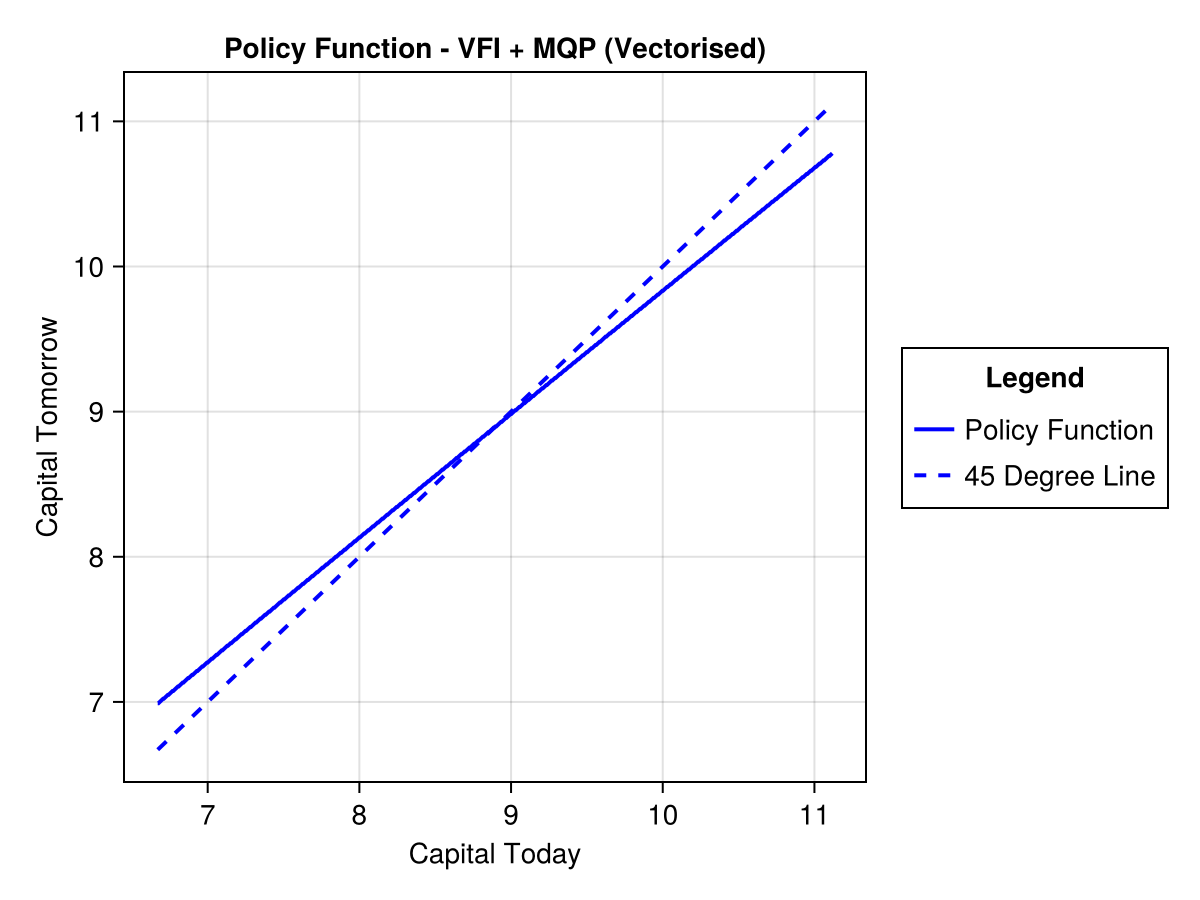

(Float32[22.619455, 22.621206, 22.622955, 22.624704, 22.626453, 22.628202, 22.629948, 22.631695, 22.63344, 22.635185  …  24.076641, 24.077898, 24.079155, 24.080412, 24.081669, 24.082926, 24.08418, 24.085438, 24.086693, 24.087946], Float32[6.9907913, 6.9907913, 6.9952383, 6.9996853, 7.0041323, 7.0085797, 7.0130267, 7.0174737, 7.0219207, 7.0219207  …  10.744117, 10.748564, 10.753011, 10.757458, 10.761905, 10.761905, 10.766353, 10.7708, 10.775247, 10.779694])

In [54]:
function mqp_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    pos_c = cons .* c_pos
    while ((error > toler) && (iter < maxiter))
        v_new = utility_vec(pos_c, pars) .+ β.*transpose(v)
        v_new[.!c_pos] .= -Inf
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]] 
        high_bound = maximum(vmax .- v) .* (β / (1 - β))
        low_bound = minimum(vmax .- v) .* (β / (1 - β))
        error = high_bound - low_bound
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        v .= vmax .+ (low_bound + high_bound)/2
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI + MQP (Vectorised)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI + MQP (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_mqp_nt_vec, pol_mqp_nt_vec = mqp_nt_vectorised(zeros(pars.grid_size,1), pars)
end 

Iterating...
--------------------
iteration 0 completed with error 23.260222659448242
--------------------
converged in 14 iterations
--------------------
  1.500374 seconds (402.12 k allocations: 53.513 MiB, 0.47% gc time, 36.50% compilation time)


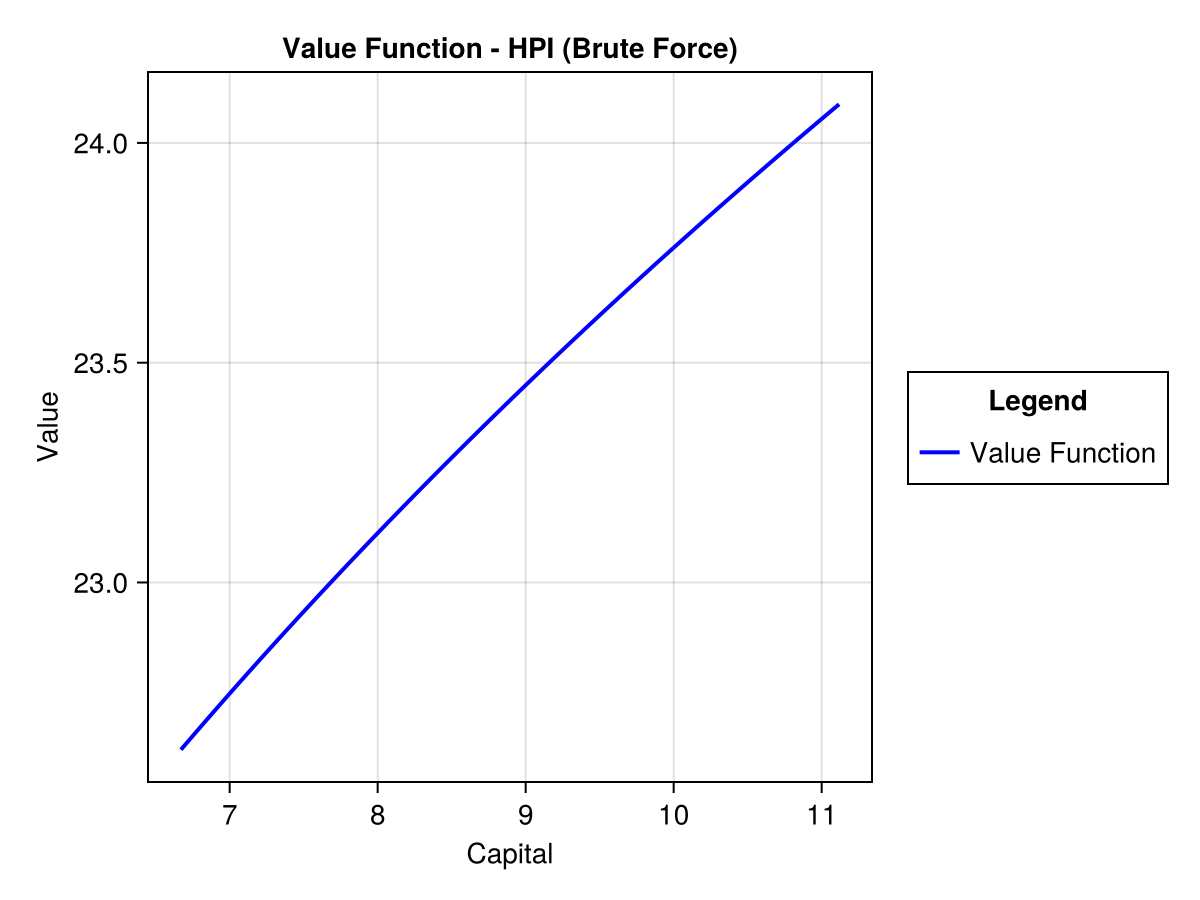

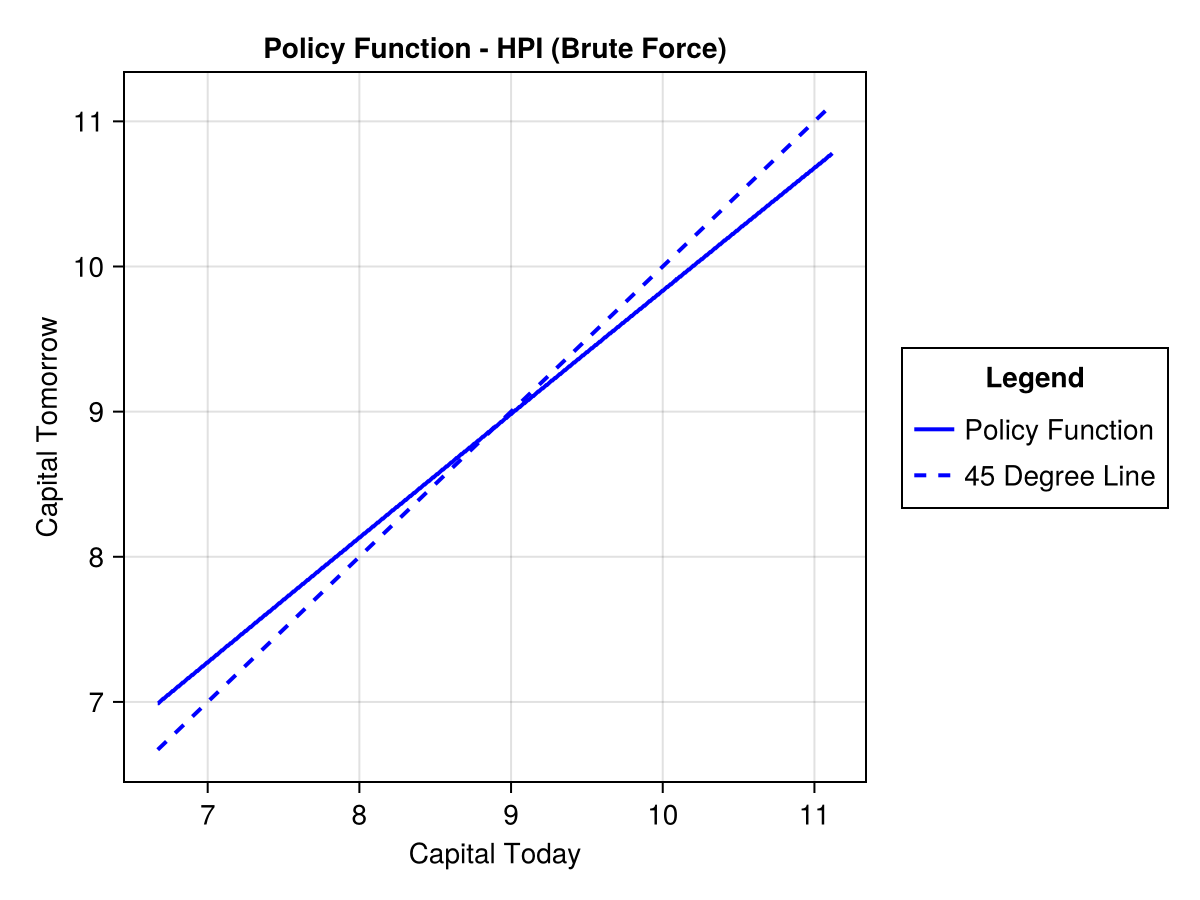

(Float32[22.619455, 22.621206, 22.622955, 22.624704, 22.626453, 22.628202, 22.629948, 22.631695, 22.63344, 22.635185  …  24.076641, 24.0779, 24.079157, 24.080414, 24.081669, 24.082926, 24.084183, 24.085438, 24.086693, 24.087946], Float32[6.9907913, 6.9907913, 6.9952383, 6.9996853, 7.0041323, 7.0085797, 7.0130267, 7.0174737, 7.0219207, 7.0219207  …  10.744117, 10.748564, 10.753011, 10.757458, 10.761905, 10.761905, 10.766353, 10.7708, 10.775247, 10.779694])

In [55]:
function howard_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler, m) = pars
    v_new = similar(v)
    v2 = similar(v)
    policy = similar(v)
    idx = zeros(Int, grid_size,1)
    Kss = ((A*α*β)/(1-β*(1-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                        idx[i] = j
                    end
                end
            end
            v_new[i] = vmax
        end
        for _ in 1:m
            for i in 1:grid_size
                j = idx[i]
                c = A*kgrid[i]^α + (1.0-δ) * kgrid[i] - policy[i]
                v2[i] = utility(c, pars) + β * v_new[j]
            end  
            v_new .= copy(v2)    
        end
        error = maximum(v_new .- v)
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new)
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - HPI (Brute Force)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - HPI (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_howard_nt, pol_howard_nt = howard_nt_brute_force(zeros(pars.grid_size,1), pars)
end

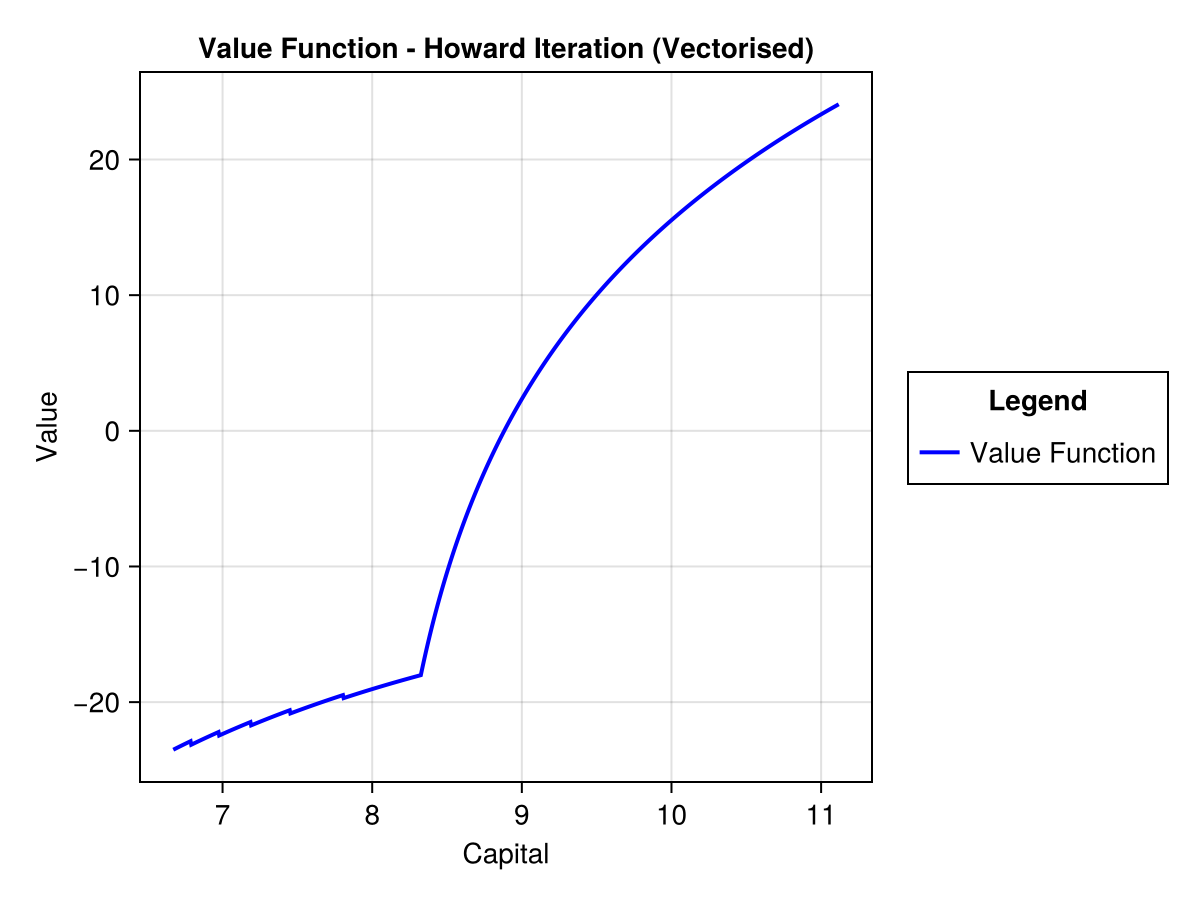

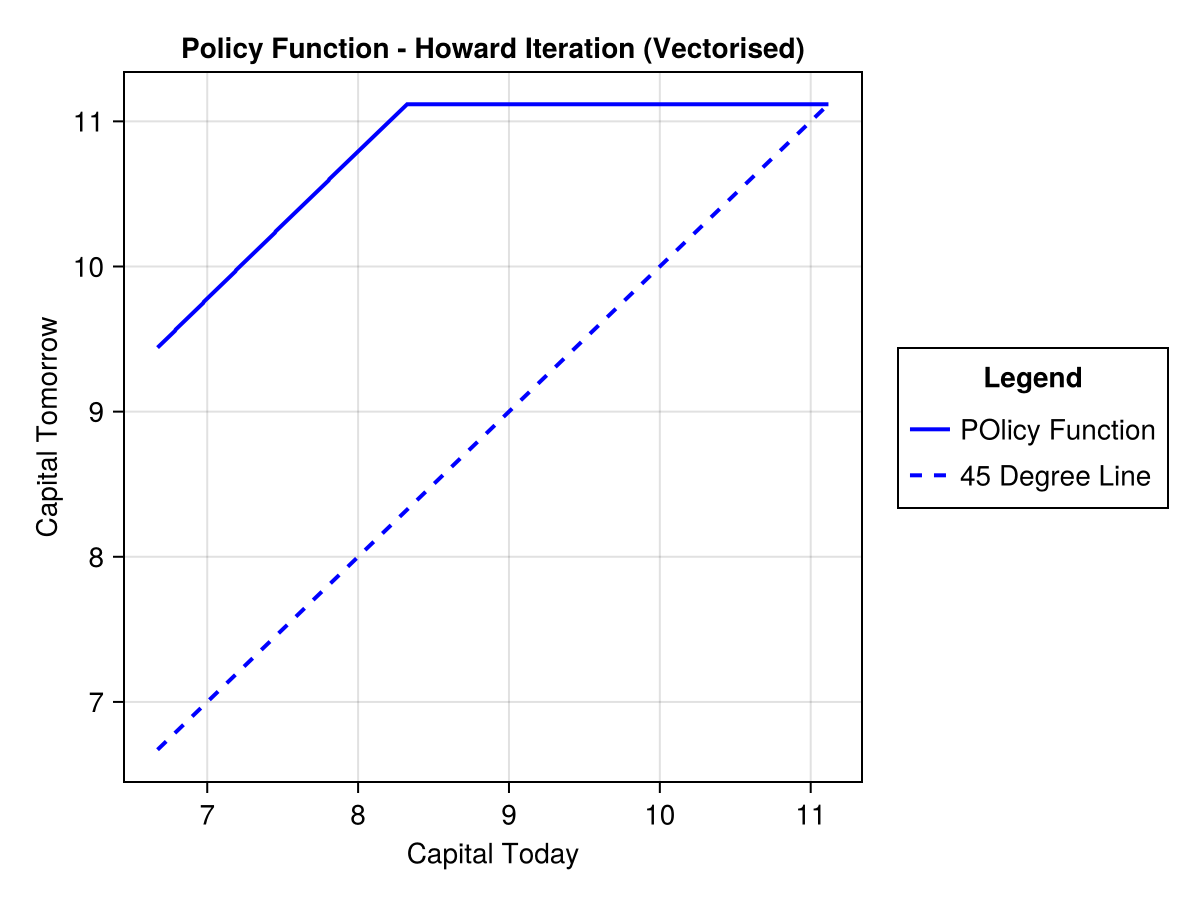

Iterating...
--------------------
iteration 0 completed with error 40.75779629912834
--------------------
converged in 2 iterations
--------------------
  1.827970 seconds (1.14 M allocations: 149.037 MiB, 0.87% gc time, 83.77% compilation time)


(Float32[-23.508543, -23.483698, -23.458906, -23.43417, -23.409489, -23.384861, -23.360287, -23.335768, -23.311302, -23.28689  …  23.822245, 23.850088, 23.87789, 23.905653, 23.933376, 23.96106, 23.988703, 24.016308, 24.043873, 24.0714], Float32[9.441126, 9.445573, 9.45002, 9.454467, 9.458914, 9.463361, 9.467809, 9.472256, 9.476703, 9.48115  …  11.117671, 11.117671, 11.117671, 11.117671, 11.117671, 11.117671, 11.117671, 11.117671, 11.117671, 11.117671])

In [56]:
function howard_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_min, grid_max, grid_size, maxiter, toler, m) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    vmax = similar(v)
    v_howard = similar(v)
    c_howard = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    kgrid = reshape(kgrid, (grid_size,1))
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    util = similar(cons)
    util_howard = similar(v)
    util[.!c_pos] .= -Inf
    util[c_pos] = utility_vec(cons[c_pos], pars)
    while ((error > toler) && (iter < maxiter))
        v_new = util .+ β.*transpose(v)
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]]
        for _ in 1:m
            new_c = A .* kgrid.^α .+ (1.0-δ) .* kgrid .- policy
            c_pos_howard = new_c .> 0
            util_howard[.!c_pos_howard] .= -Inf
            util_howard[c_pos_howard] = utility_vec(new_c[c_pos_howard], pars)
            v_howard = util_howard .+ β .* vmax
            vmax .= v_howard
        end
        error = maximum(vmax .- v)
        v .= vmax
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - Howard Iteration (Vectorised)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - Howard Iteration (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "POlicy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_howard_nt_vec, pol_howard_nt_vec = howard_nt_vectorised(zeros(pars.grid_size,1), pars)
end